<a href="https://colab.research.google.com/github/eduardburlacu/Transformer/blob/master/ConvolutionalAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

In [47]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
else: DEVICE = torch.device('cpu')
print(print(
    f"Training on {DEVICE} using PyTorch {torch.__version__}")
)

Training on cuda using PyTorch 2.0.1+cu118
None


In [48]:
class Encoder(nn.Module):
  def __init__(self, input_channels:int =1,*args, **kwargs):
    super(Encoder, self).__init__(*args, **kwargs)
    self.input_channels = input_channels
    self.layer1 = nn.Conv2d(self.input_channels, 20, 3)
    self.layer2 = nn.Conv2d(20, 10, 3)
    self.layer3 = nn.Conv2d(10, 5, 3)
    self.layer4 = nn.Conv2d(5, 3, 3)

  def forward(self, x):
    y = F.relu(self.layer1(x))
    y = F.relu(self.layer2(y))
    y = F.relu(self.layer3(y))
    y = self.layer4(y)
    return y


class Decoder(nn.Module):
  def __init__(self, output_channels:int =1,*args, **kwargs):
    super(Decoder, self).__init__(*args, **kwargs)
    self.output_channels = output_channels
    self.layer1 = nn.ConvTranspose2d(3,5, 3)
    self.layer2 = nn.ConvTranspose2d(5,10,3)
    self.layer3 = nn.ConvTranspose2d(10,20,3)
    self.layer4 = nn.ConvTranspose2d(20,self.output_channels,3)

  def forward(self, x):
    y = F.relu(self.layer1(x))
    y = F.relu(self.layer2(y))
    y = F.relu(self.layer3(y))
    y = self.layer4(y)
    return y


class Autoencoder(nn.Module):
  def __init__(self,*args,**kwargs):
    super(Autoencoder,self).__init__(*args,**kwargs)
    self.encoder = Encoder(*args,**kwargs)
    self.decoder = Decoder(*args,**kwargs)

  def forward(self, x):
    y = self.encoder(x)
    y = self.decoder(y)
    return y


In [49]:
x = torch.rand([7,1,28,28])
encoder = Encoder()
decoder = Decoder()
y = encoder(x)
z= decoder(y)
print(y.shape,z.shape)

torch.Size([7, 3, 20, 20]) torch.Size([7, 1, 28, 28])


In [50]:
DATASET = torchvision.datasets.MNIST
EPOCHS = 3
BATCH_SIZE = 32
SPLIT_FN = torch.utils.data.random_split
VAL_SPLIT = 0.35
SEED = 90
SHAPE =(1,28,28)

def load_datasets(dataset = DATASET, batch_size = BATCH_SIZE, split_fn = SPLIT_FN, val_split = VAL_SPLIT ,seed:int = SEED):
    '''
    Given a dataset, batch size, and validation dataset fraction, it returns 3 lists of corresponding DataLoaders for train, validation, test
    :param val_split: float
    :param seed: int
    '''
    # Download and transform dataset (train and test)
    normalizer=transforms.Normalize([0.5]*SHAPE[0], [0.5]*SHAPE[0])
    transform = transforms.Compose(
        [transforms.ToTensor(),
         normalizer,
         ]
    )
    trainvalset = dataset("./dataset", train=True, download=True, transform=transform)
    testset  = dataset("./dataset", train=False,download=True, transform=transform)
    len_val = int( len(trainvalset) * val_split )
    len_train = len(trainvalset) - len_val
    lengths = [len_train, len_val]
    trainset, valset = split_fn(trainvalset, lengths, torch.Generator().manual_seed(seed))
    trainloader =DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
    valloader   =DataLoader(valset, batch_size=BATCH_SIZE)
    testloader  =DataLoader(testset, batch_size=BATCH_SIZE)
    return trainloader, valloader, testloader

trainloader, valloader, testloader =load_datasets()

In [51]:
def train(net, trainloader, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.MSELoss()
    optimizer = optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-5)
    for _ in range(epochs):
        for images, _ in trainloader:
            images = images.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(net(images), images)
            loss.backward()
            #for name, param in net.named_parameters():
            #    if param.grad is not None:
            #        print(f"Layer: {name}, Gradients: {param.grad.mean()}")
            optimizer.step()

def test(net, testloader):
    """Validate the network on the entire test set."""
    criterion = torch.nn.MSELoss()
    correct, total, loss = 0, 0, 0.0
    with torch.no_grad():
        for images,_ in testloader:
            images = images.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, images).item()
    return loss

In [7]:
net = Autoencoder()
net= net.to(DEVICE)

for epoch in range(EPOCHS):
    train(net, trainloader, 1)
    loss = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}")

loss = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}")

Epoch 1: validation loss 1.4579142121365294
Epoch 2: validation loss 1.0587563860462978
Epoch 3: validation loss 1.0201880926615559
Final test set performance:
	loss 0.48209201433928683


In [53]:
from itertools import product
from collections import OrderedDict
BATCH_SIZES = (60,80,100,120,140)
EPOCHS = 15
best= float('inf')
weights = None
hyperparam_space=[]
for batch_size in BATCH_SIZES:
  load_datasets(dataset = DATASET, batch_size = batch_size, split_fn = SPLIT_FN, val_split = VAL_SPLIT ,seed = SEED)
  torch.manual_seed(68)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(68)
  net = Autoencoder()
  net= net.to(DEVICE)

  for epoch in range(1,EPOCHS):
    print(f'----------Training on {batch_size} batch size and {epoch} epochs-----------')
    train(net, trainloader, 1)
    loss = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}")
    test_loss = test(net, testloader)
    print(f"Final test set performance:\n\tloss {test_loss}\n")
    if test_loss<best:
      best = test_loss
      weights = OrderedDict({name:val.cpu() for name, val in net.state_dict().items()})
    hyperparam_space.append([batch_size,epoch, test_loss])
net.load_state_dict(weights, strict=True)

----------Training on 60 batch size and 1 epochs-----------
Epoch 2: validation loss 1.2969369174097665
Final test set performance:
	loss 0.5957743800245225

----------Training on 60 batch size and 2 epochs-----------
Epoch 3: validation loss 0.7673025402182247
Final test set performance:
	loss 0.3446513739763759

----------Training on 60 batch size and 3 epochs-----------
Epoch 4: validation loss 2.300071899779141
Final test set performance:
	loss 1.0783536825329065

----------Training on 60 batch size and 4 epochs-----------
Epoch 5: validation loss 0.806939072383102
Final test set performance:
	loss 0.36805600638035685

----------Training on 60 batch size and 5 epochs-----------
Epoch 6: validation loss 1.4243860534625128
Final test set performance:
	loss 0.6623334916075692

----------Training on 60 batch size and 6 epochs-----------
Epoch 7: validation loss 0.5510413896408863
Final test set performance:
	loss 0.25384330851375125

----------Training on 60 batch size and 7 epochs----

<All keys matched successfully>

In [54]:
print(f'Best loss: {best}')
torch.save(net.state_dict(), 'conv_autoencoder_raw.pth')

Best loss: 0.14094651908089872


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
# batch   epoch   loss
x_data, y_data, f_data = zip(*hyperparam_space)
x_grid, y_grid = np.meshgrid(np.linspace(min(x_data), max(x_data), 100),
                             np.linspace(min(y_data), max(y_data), 100))

f_interp = griddata((x_data, y_data), f_data, (x_grid, y_grid), method='cubic')


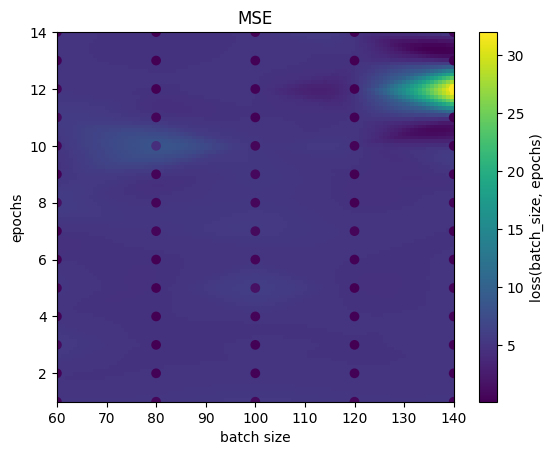

In [56]:
plt.imshow(f_interp, extent=(min(x_data), max(x_data), min(y_data), max(y_data)),
           origin='lower', aspect='auto')
plt.scatter(x_data, y_data, c=f_data, cmap='viridis')  # Optional: plot the original data points
plt.colorbar(label='loss(batch_size, epochs)')  # Optional: Add a colorbar for f(x, y) values
plt.xlabel('batch size')
plt.ylabel('epochs')
plt.title('MSE')
plt.show()

In [57]:
BATCH_SIZES = (150,160)
EPOCHS = 16
hyperparam_space_tuned=[]
best_tuned = float('inf')
weights_tuned = None
for batch_size in BATCH_SIZES:

  torch.manual_seed(68)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(68)
  net_tuned = Autoencoder()
  net_tuned= net_tuned.to(DEVICE)

  for epoch in range(1,EPOCHS):
    print(f'----------Training on {batch_size} batch size and {epoch} epochs-----------')
    train(net_tuned, trainloader, 1)
    loss = test(net_tuned, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}")
    test_loss = test(net_tuned, testloader)
    print(f"Final test set performance:\n\tloss {test_loss}\n")
    if test_loss<best_tuned:
      best_tuned = test_loss
      weights_tuned = OrderedDict({name:val.cpu() for name, val in net_tuned.state_dict().items()})
    hyperparam_space_tuned.append([batch_size,epoch, test_loss])
net_tuned.load_state_dict(weights_tuned, strict=True)

----------Training on 150 batch size and 1 epochs-----------
Epoch 2: validation loss 1.3426605323329568
Final test set performance:
	loss 0.6207475163391791

----------Training on 150 batch size and 2 epochs-----------
Epoch 3: validation loss 0.8352311707567424
Final test set performance:
	loss 0.38413256529020146

----------Training on 150 batch size and 3 epochs-----------
Epoch 4: validation loss 0.42149085785786156
Final test set performance:
	loss 0.192750746908132

----------Training on 150 batch size and 4 epochs-----------
Epoch 5: validation loss 0.9957976397126913
Final test set performance:
	loss 0.46107411629054695

----------Training on 150 batch size and 5 epochs-----------
Epoch 6: validation loss 0.516245619073743
Final test set performance:
	loss 0.2369319452845957

----------Training on 150 batch size and 6 epochs-----------
Epoch 7: validation loss 1.1225259258062579
Final test set performance:
	loss 0.5180773921892978

----------Training on 150 batch size and 7 ep

<All keys matched successfully>

In [65]:
print(f'Best loss: {best_tuned}')
torch.save(net.state_dict(), 'conv_autoencoder.pth')
torch.save(net_tuned.state_dict(), 'conv_autoencoder_tuned.pth')

Best loss: 0.1459909698460251


In [60]:
x_tuned,y_tuned,f_tuned=zip(*hyperparam_space_tuned)
x_datat = list(x_data)
x_datat.extend(list(x_tuned))
y_datat = list(y_data)
y_datat.extend(list(y_tuned))
f_datat = list(f_data)
f_datat.extend(list(f_tuned))

In [61]:
print(f_datat)

[0.5957743800245225, 0.3446513739763759, 1.0783536825329065, 0.36805600638035685, 0.6623334916075692, 0.25384330851375125, 0.2338957131432835, 1.3952232357114553, 0.37338548101251945, 0.5617255177930929, 1.1582841090857983, 0.5689306306303479, 0.3363040604162961, 0.3886248532216996, 0.6439718997571617, 0.3018286875449121, 0.2064391481981147, 0.23025744513142854, 0.16566016171418596, 0.17501215753145516, 0.5683284913538955, 0.4931535263895057, 0.5131688179681078, 4.354198922403157, 0.5807628250913695, 0.2081475484301336, 0.18777780036907643, 0.15620700348517857, 0.905996432993561, 0.37576726329280064, 0.31779915394145064, 0.4522425540490076, 1.5969663022551686, 0.4844261402031407, 0.9817895879969001, 0.7388307012151927, 0.7916255174204707, 0.7218156775925308, 0.278964471508516, 0.2852466047042981, 0.36744631733745337, 0.399110873171594, 0.6586401235545054, 0.3166544684499968, 0.25191877235192806, 0.28616519807837903, 0.15529388427967206, 0.2716914003540296, 0.5145457059843466, 0.1409465

In [62]:

x_gridt, y_gridt = np.meshgrid(np.linspace(min(x_datat), max(x_datat), 100),
                             np.linspace(min(y_datat), max(y_datat), 100))

f_interpt = griddata((x_datat, y_datat), f_datat, (x_gridt, y_gridt), method='cubic')


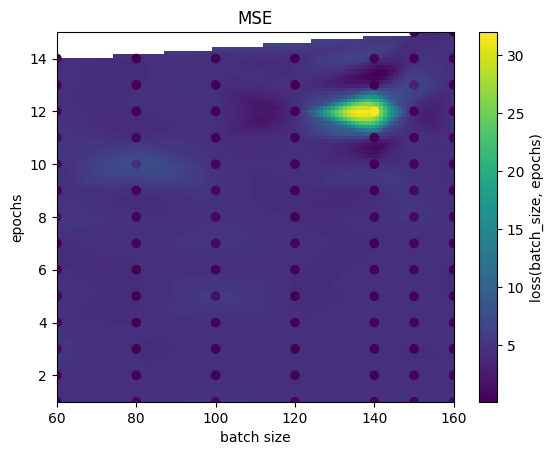

In [63]:
plt.imshow(f_interpt, extent=(min(x_datat), max(x_datat), min(y_datat), max(y_datat)),
           origin='lower', aspect='auto')
plt.scatter(x_datat, y_datat, c=f_datat, cmap='viridis')  # Optional: plot the original data points
plt.colorbar(label='loss(batch_size, epochs)')  # Optional: Add a colorbar for f(x, y) values
plt.xlabel('batch size')
plt.ylabel('epochs')
plt.title('MSE')
plt.show()